In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2021-05-12 04:22:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-12 04:22:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-12 04:22:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data1 =  pd.read_json( '/content/drive/MyDrive/datasets/dataset1/Sarcasm_Headlines_Dataset_v2.json', lines=True)

data2 =  pd.read_json( '/content/drive/MyDrive/final_year_project/demo.json', lines=True)
data= pd.concat([data1,data2])
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
!unzip glove*.zip


Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Preprocessing, Embedding and Tokenisation

In [ ]:
nembeddings_index = {}
embedding_dim = 100
f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index)) 

Found 400000 word vectors.


In [ ]:
from collections import defaultdict
abb_dict=defaultdict()
hash_dict=defaultdict()
off_dict=defaultdict()
emo_dict=defaultdict()
spell_dict=defaultdict()
def loadEmo():
  with open("/content/drive/MyDrive/final_year_project/emoji.txt") as fp:
    lines=fp.readlines()
    for l in lines:
      token=l.lower().strip().split('\t')
      emo_dict[token[0]]=token[1]
  return


def loadOff():
  with open("/content/drive/MyDrive/final_year_project/Off.txt") as fp:
    lines=fp.readlines()
    for l in lines:
      token=l.lower().strip()
      off_dict[token]="value"
  return


def loadHash():
  with open("/content/drive/MyDrive/final_year_project/hsh.txt") as fp:
    lines=fp.readlines()
    for l in lines:
      token=l.lower().strip().split('\t')
      hash_dict[token[0]]=token[1]
  return
def loadAbb():
  with open("/content/drive/MyDrive/final_year_project/abb.txt") as fp:
    lines=fp.readlines()
    for l in lines:
      token=l.lower().strip().split('\t')
      abb_dict[token[0]]=token[1]
  return
def loadSpell():
  with open("/content/drive/MyDrive/final_year_project/spell.txt") as fp:
    lines=fp.readlines()
    for l in lines:
      token=l.lower().strip().split('\t')
      spell_dict[token[0]]=token[1]
  return

In [ ]:

def rem_abb(text):
  splits=text.split()
  for t in splits:
    if(t in abb_dict):
      text=re.sub(r"{}".format(t),"{}".format(abb_dict.get(t)),text)
  return text

def rem_hash(text):
  splits=text.split()
  for t in splits:
    ##print(t)
    if(t in hash_dict):
      text=re.sub(r"{}".format(t),"{}".format(hash_dict.get(t)),text)
  return text

def rem_emo(text):
  splits=text.split()
  for t in splits:
    if(t in emo_dict):
      text=re.sub(r"{}".format(t),"",text)
  return text
def rem_off(text):
  splits=text.split()
  for t in splits:
    if(t in off_dict):
      text=re.sub(r"{}".format(t),"",text)
  return text
def rem_spell(text):
  splits=text.split()
  for t in splits:
    if(t in spell_dict):
      text=re.sub(r"{}".format(t),"{}".format(spell_dict.get(t)),text)
  return text

In [ ]:
def normalize_word(word):
    temp = word
    while True:
        w = re.sub(r"([a-zA-Z])\1\1", r"\1\1", temp)
        if (w == temp):
            break
        else:
            temp = w
    return w

In [ ]:
normalize_word("i ccannnnot believe this")

'i ccannot believe this'

In [ ]:
loadAbb()
loadEmo()
loadHash()
loadOff()
loadSpell()
def proc(text):
  text=rem_hash(text)
  text=normalize_word(text)
  text=rem_spell(text)
  #text=text.lower()
  text=rem_abb(text)
  text=rem_emo(text)
  text=rem_off(text)
  return text

In [ ]:
proc("10k walk this morning. We did an awesome job.")

'10k walk this morning. We did an awesome job.'

In [ ]:
from collections import Counter
cnt=Counter()
for text in data["headline"].values:
  for word in text.split():
    cnt[word]+=1
cnt.most_common(25)
freq=set([w for (w, wc) in cnt.most_common(25)])
def fre(text):
  return " ".join([word for word in str(text).split() if word not in freq])

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob 
def spell(text):
  textBlb=TextBlob(text)
  textCorrected=textBlb.correct()
  #print(type(textCorrected))
  return str(textCorrected)

In [ ]:

def clean_text(text):
    text = text.lower()
    text=re.sub(r","," ",text)
    text=re.sub(r"!"," ",text)
    text=re.sub(r"\."," ",text)
    text=re.sub(r"\?"," ",text)
    text= re.sub(r"#sarcasm","",text)
    #text= re.sub(r"#not","",text)
    text=re.sub(r"#sarcastictweet","",text)
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub(' ', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text=proc(text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    #text=re.sub(r"sarcasm","",text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", " ", text)
    return text    

In [ ]:
clean_text("10k walk this morning. We did an awesome job.")

'10k walk this morning we did an awesome job'

In [ ]:
import nltk
import gensim
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def cln_tkn(token):
  return [i for i in token if len(i)>2]

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        line=remove_stopwords(line)
        word_list=nltk.word_tokenize(line)
        lemmatizer=WordNetLemmatizer()
        line=" ".join([lemmatizer.lemmatize(w) for w in word_list])
        line=fre(line)
        #line=spell(line)
        # tokenize the text
        tokens = word_tokenize(line)
        #tokens=cln_tkn(tokens)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        ##words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['thirtysomething',
  'scientist',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep',
  'totally',
  'nail',
  'congress',
  'falling',
  'short',
  'gender',
  'racial',
  'equality'],
 ['eat', 'veggie', 'deliciously', 'different', 'recipe'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother', 'come', 'pretty', 'close', 'word', 'streaming', 'correctly'],
 ['white', 'inheritance'],
 ['way', 'file', 'tax', 'stress'],
 ['richard',
  'branson',
  's',
  'global',
  'warming',
  'donation',
  'nearly',
  'cost',
  'failed',
  'balloon',
  'trip'],
 ['shadow',
  'government',
  'getting',
  'large',
  'meet',
  'marriott',
  'conference',
  'room'],
 ['lot', 'parent', 'know', 'scenario']]

(-0.5, 999.5, 499.5, -0.5)

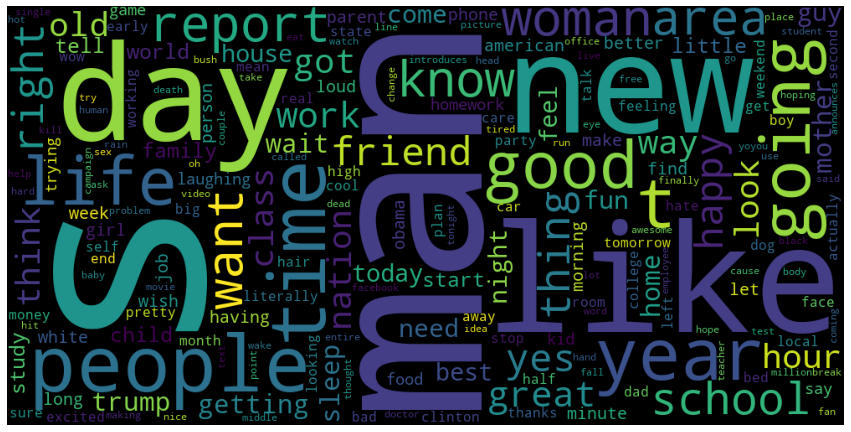

In [ ]:


from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  32786
vocab size - 32787


In [ ]:

print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (71063, 25)
Shape of y_train: (71063,)
Shape of X_test_pad: (17765, 25)
Shape of y_test: (17765,)


In [ ]:

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

27073


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# CNN+RNN

In [ ]:
from keras import Sequential, Model
from keras.layers import Embedding,LSTM, GlobalMaxPool1D,Dense,Dropout,Bidirectional,GRU

In [ ]:
rcnn= Sequential()
rcnn.add(embedding_layer)
rcnn.add(tf.keras.layers.Conv1D(128,1,activation='relu'))
rcnn.add(tf.keras.layers.MaxPooling1D(2,padding='same'))
rcnn.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
rcnn.add(tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.l1(0.005),activation='relu'))
rcnn.add(tf.keras.layers.Dropout(0.5))
rcnn.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005),activation='sigmoid'))

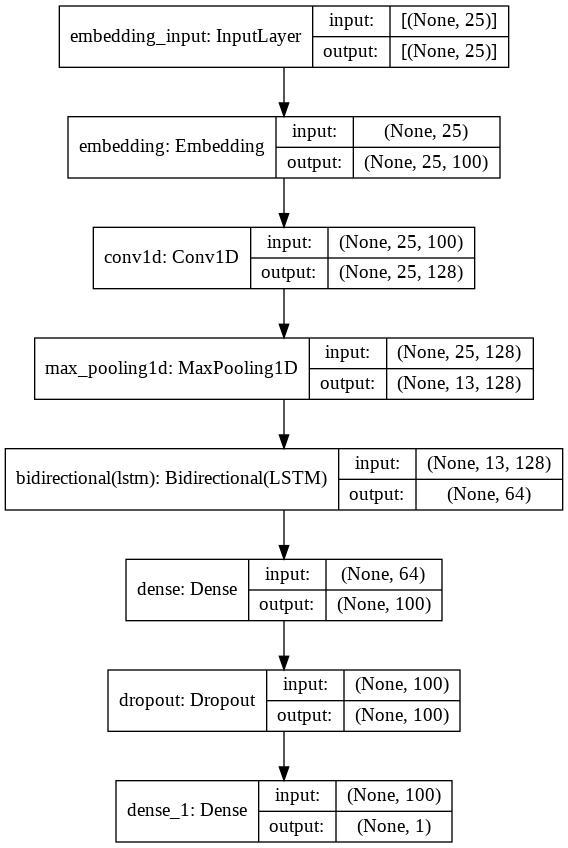

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(rcnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
rcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mcr = tf.keras.callbacks.ModelCheckpoint('model_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
historyr = rcnn.fit(X_train_pad, y_train,
                    epochs=40, callbacks=[mcr], 
                    validation_split=0.1, verbose=2)

Epoch 1/40
1999/1999 - 36s - loss: 0.7764 - accuracy: 0.6557 - val_loss: 0.6150 - val_accuracy: 0.7182

Epoch 00001: val_accuracy improved from -inf to 0.71817, saving model to model_best.hdf5
Epoch 2/40
1999/1999 - 31s - loss: 0.6164 - accuracy: 0.7160 - val_loss: 0.5883 - val_accuracy: 0.7383

Epoch 00002: val_accuracy improved from 0.71817 to 0.73829, saving model to model_best.hdf5
Epoch 3/40
1999/1999 - 31s - loss: 0.5896 - accuracy: 0.7412 - val_loss: 0.5663 - val_accuracy: 0.7509

Epoch 00003: val_accuracy improved from 0.73829 to 0.75095, saving model to model_best.hdf5
Epoch 4/40
1999/1999 - 31s - loss: 0.5682 - accuracy: 0.7584 - val_loss: 0.5461 - val_accuracy: 0.7661

Epoch 00004: val_accuracy improved from 0.75095 to 0.76615, saving model to model_best.hdf5
Epoch 5/40
1999/1999 - 31s - loss: 0.5488 - accuracy: 0.7730 - val_loss: 0.5411 - val_accuracy: 0.7668

Epoch 00005: val_accuracy improved from 0.76615 to 0.76685, saving model to model_best.hdf5
Epoch 6/40
1999/1999 - 

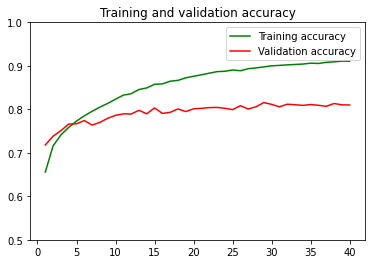

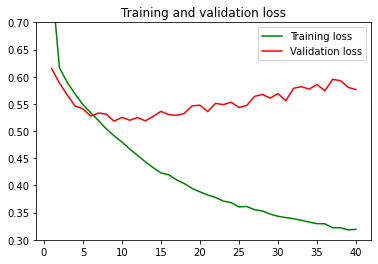

In [ ]:
acc = historyr.history['accuracy']
val_acc = historyr.history['val_accuracy']
loss = historyr.history['loss']
val_loss = historyr.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.ylim([.5,1])
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylim([.3,.7])
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import sklearn

In [ ]:
y_preds = rcnn.predict(X_test_pad, batch_size=32).round().astype(int)
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))

Test accuracy score 0.8034337179848016


In [ ]:
 from sklearn.metrics import f1_score
 f1_sc=f1_score(y_test, y_preds, average='binary')
 f1_sc

0.792907128454513

In [ ]:
p=precision_score(y_test, y_preds, average='binary')
p

0.7735477898634575

In [ ]:
r=recall_score(y_test, y_preds, average='binary')
r

0.8132603406326034

# Simple LSTM

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           3278700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,321,005
Trainable params: 42,305
Non-trainable params: 3,278,700
_________________________________________________________________
None


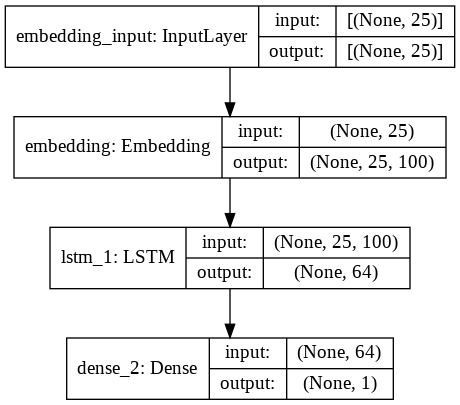

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('lstm_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train_pad, y_train,
                    epochs=40, callbacks=[mc], 
                    validation_split=0.1, verbose=2)

Epoch 1/40
1999/1999 - 71s - loss: 0.6123 - accuracy: 0.6586 - val_loss: 0.5497 - val_accuracy: 0.7116

Epoch 00001: val_accuracy improved from -inf to 0.71155, saving model to lstm_best.hdf5
Epoch 2/40
1999/1999 - 69s - loss: 0.5576 - accuracy: 0.7071 - val_loss: 0.5160 - val_accuracy: 0.7418

Epoch 00002: val_accuracy improved from 0.71155 to 0.74180, saving model to lstm_best.hdf5
Epoch 3/40
1999/1999 - 67s - loss: 0.5281 - accuracy: 0.7310 - val_loss: 0.4987 - val_accuracy: 0.7590

Epoch 00003: val_accuracy improved from 0.74180 to 0.75897, saving model to lstm_best.hdf5
Epoch 4/40
1999/1999 - 68s - loss: 0.5060 - accuracy: 0.7464 - val_loss: 0.4801 - val_accuracy: 0.7647

Epoch 00004: val_accuracy improved from 0.75897 to 0.76474, saving model to lstm_best.hdf5
Epoch 5/40
1999/1999 - 68s - loss: 0.4889 - accuracy: 0.7576 - val_loss: 0.4764 - val_accuracy: 0.7652

Epoch 00005: val_accuracy improved from 0.76474 to 0.76516, saving model to lstm_best.hdf5
Epoch 6/40
1999/1999 - 68s -

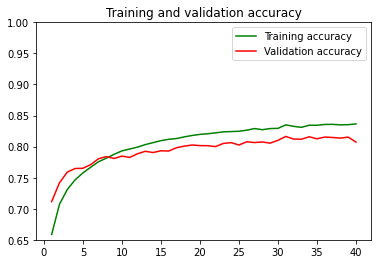

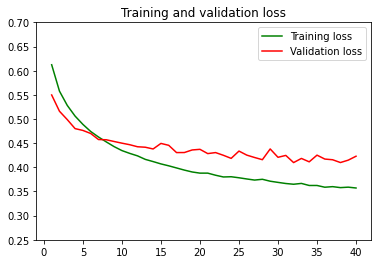

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.ylim([.65,1])
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylim([.25,.7])
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import sklearn

In [ ]:
y_preds = model.predict(X_test_pad, batch_size=32).round().astype(int)
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))

Test accuracy score 0.8081058260624824


In [ ]:
 from sklearn.metrics import f1_score
 f1_sc=f1_score(y_test, y_preds, average='binary')
 f1_sc

0.7794241345842771

In [ ]:
p=precision_score(y_test, y_preds, average='binary')
p

0.8324809951624049

In [ ]:
r=recall_score(y_test, y_preds, average='binary')
r

0.7327250608272506

#BiLSTM

In [ ]:
model1 = Sequential()
model1.add(embedding_layer)
model1.add(Bidirectional(tf.keras.layers.LSTM(64)))
#model1.add(GlobalMaxPool1D())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model1.summary())

Summary of the built model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           3278700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)         

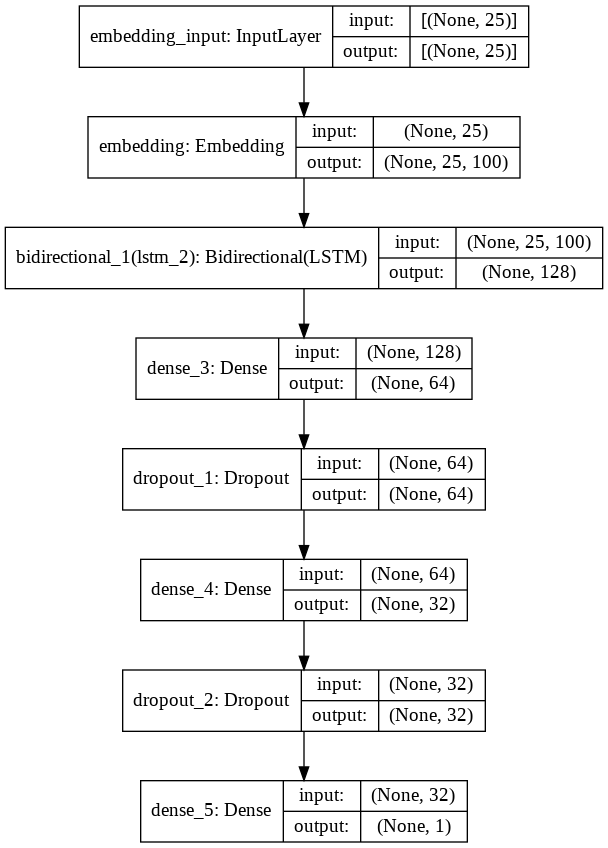

In [ ]:
plot_model(model1, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc1 = tf.keras.callbacks.ModelCheckpoint('bilstm_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history1 = model1.fit(X_train_pad, y_train,
                    epochs=40, callbacks=[mc1], 
                    validation_split=0.1, verbose=2)

Epoch 1/40
1999/1999 - 52s - loss: 0.5963 - accuracy: 0.6776 - val_loss: 0.5241 - val_accuracy: 0.7353

Epoch 00001: val_accuracy improved from -inf to 0.73533, saving model to bilstm_best.hdf5
Epoch 2/40
1999/1999 - 48s - loss: 0.5153 - accuracy: 0.7433 - val_loss: 0.4873 - val_accuracy: 0.7564

Epoch 00002: val_accuracy improved from 0.73533 to 0.75644, saving model to bilstm_best.hdf5
Epoch 3/40
1999/1999 - 49s - loss: 0.4580 - accuracy: 0.7804 - val_loss: 0.4574 - val_accuracy: 0.7760

Epoch 00003: val_accuracy improved from 0.75644 to 0.77600, saving model to bilstm_best.hdf5
Epoch 4/40
1999/1999 - 48s - loss: 0.4035 - accuracy: 0.8136 - val_loss: 0.4473 - val_accuracy: 0.7875

Epoch 00004: val_accuracy improved from 0.77600 to 0.78753, saving model to bilstm_best.hdf5
Epoch 5/40
1999/1999 - 48s - loss: 0.3552 - accuracy: 0.8413 - val_loss: 0.4367 - val_accuracy: 0.8024

Epoch 00005: val_accuracy improved from 0.78753 to 0.80245, saving model to bilstm_best.hdf5
Epoch 6/40
1999/19

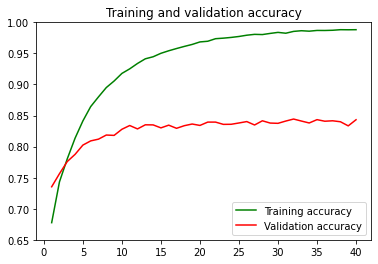

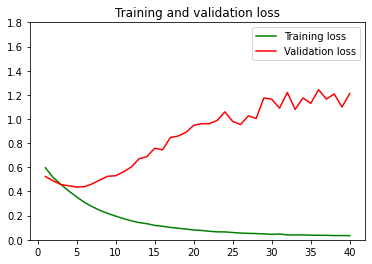

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.ylim([.65,1.0])
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylim([.0,1.8])
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import sklearn

In [ ]:
y_preds1 = model1.predict(X_test_pad, batch_size=32).round().astype(int)
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds1))

Test accuracy score 0.8321418519560935


In [ ]:
y_preds1.shape

(17765, 1)

In [ ]:
matrix = confusion_matrix(y_test, y_preds1)
print(matrix)

[[8030 1515]
 [1467 6753]]


In [ ]:
f1_sc1=f1_score(y_test, y_preds1, average='binary')
f1_sc1

0.8191411935953421

In [ ]:
p1=precision_score(y_test, y_preds1, average='binary')
p1

0.8167634252539913

In [ ]:
r1=recall_score(y_test, y_preds1, average='binary')
r1

0.8215328467153284

# BiGRU

In [ ]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Bidirectional(tf.keras.layers.GRU(64)))
#model2.add(GlobalMaxPool1D())
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
#model2.add(Dense(32, activation='relu'))
#model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model2.summary())

Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           3278700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               63744     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,346,605
Trainable params: 67,905
Non-trainable params: 3,278,700
_________________________________________________________________
None


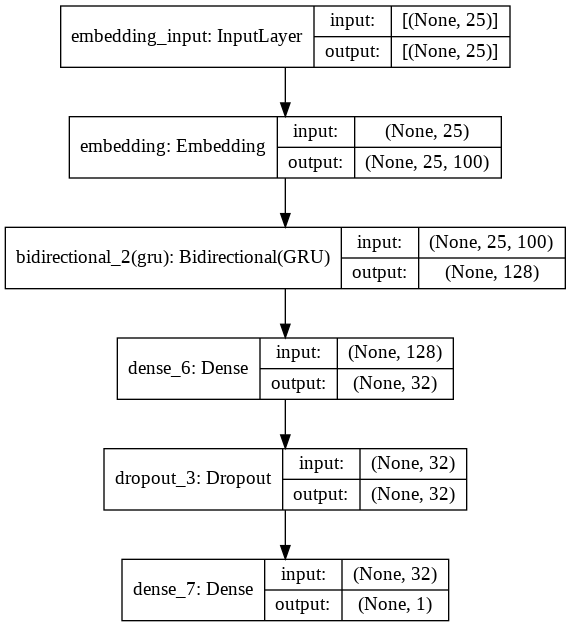

In [ ]:
plot_model(model2, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc2 = tf.keras.callbacks.ModelCheckpoint('bigru_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history2 = model2.fit(X_train_pad, y_train,
                    epochs=40, callbacks=[mc2], 
                    validation_split=0.1, verbose=2)

Epoch 1/40
1999/1999 - 50s - loss: 0.5865 - accuracy: 0.6813 - val_loss: 0.5288 - val_accuracy: 0.7297

Epoch 00001: val_accuracy improved from -inf to 0.72970, saving model to bigru_best.hdf5
Epoch 2/40
1999/1999 - 50s - loss: 0.5157 - accuracy: 0.7396 - val_loss: 0.4943 - val_accuracy: 0.7577

Epoch 00002: val_accuracy improved from 0.72970 to 0.75770, saving model to bigru_best.hdf5
Epoch 3/40
1999/1999 - 45s - loss: 0.4677 - accuracy: 0.7713 - val_loss: 0.4801 - val_accuracy: 0.7598

Epoch 00003: val_accuracy improved from 0.75770 to 0.75981, saving model to bigru_best.hdf5
Epoch 4/40
1999/1999 - 46s - loss: 0.4255 - accuracy: 0.7978 - val_loss: 0.4653 - val_accuracy: 0.7719

Epoch 00004: val_accuracy improved from 0.75981 to 0.77192, saving model to bigru_best.hdf5
Epoch 5/40
1999/1999 - 45s - loss: 0.3867 - accuracy: 0.8197 - val_loss: 0.4721 - val_accuracy: 0.7780

Epoch 00005: val_accuracy improved from 0.77192 to 0.77797, saving model to bigru_best.hdf5
Epoch 6/40
1999/1999 - 

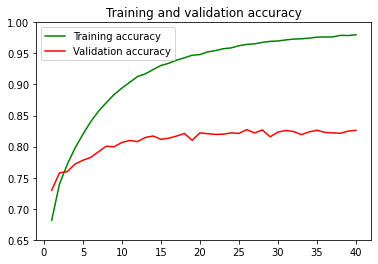

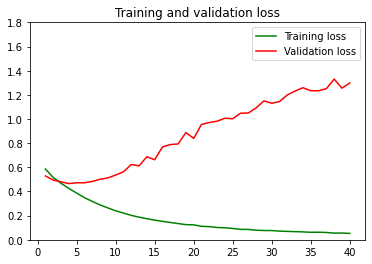

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.ylim([.65,1.0])
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylim([.0,1.8])
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import sklearn

In [ ]:
y_preds2 = model2.predict(X_test_pad).round().astype(int)
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds2))

Test accuracy score 0.8273008725021109


In [ ]:
y_preds2.shape

(17765, 1)

In [ ]:
matrix = confusion_matrix(y_test, y_preds2)
print(matrix)

[[8017 1528]
 [1540 6680]]


In [ ]:
f1_sc2=f1_score(y_test, y_preds2, average='binary')
f1_sc2

0.8132456781105429

In [ ]:
p2=precision_score(y_test, y_preds2, average='binary')
p2

0.8138401559454191

In [ ]:
r2=recall_score(y_test, y_preds2, average='binary')
r2

0.8126520681265207

In [ ]:
def lsp(s):
  pred=model.predict(s)
  pred*=100
  return pred[0][0]

In [ ]:
def bilsp(s):
  pred=model1.predict(s)
  pred*=100
  return pred[0][0]

In [ ]:
def bigrp(s):
  pred=model2.predict(s)
  pred*=100
  return pred[0][0]

In [ ]:
def rc(s):
  pred=rcnn.predict(s)
  pred*=100
  return pred[0][0]

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = rc(test_review_pad)*0.2+lsp(test_review_pad)*0.22+ bilsp(test_review_pad)*0.31 +bigrp( test_review_pad)*0.27
    #print(pred[0][0])
    if pred>=55: return "That was sarcastic"
    elif pred<55: return "Seems like it wasn't sarcastic"

In [ ]:
predict_sarcasm("Hello, I'm new here. Please take good care of me")

"Seems like it wasn't sarcastic"

In [ ]:
"""with open("/content/drive/MyDrive/sample.txt") as fp:
  lines=fp.readlines()
  count=0
  c=0
  for l in lines:
    token=l.lower().strip().split('\t')
    val=int(token[1])
    res=predict_sarcasm(token[0])
    if val==res:
      count+=1
    c+=1
    print("{}-->accuracy: {}".format(c,count/c))
  tst_acc=count/7500
  print(tst_acc)"""

In [ ]:
print(tst_acc)

In [ ]:
with open("/content/drive/MyDrive/final_year_project/hhh.txt") as fp:
  lines=fp.readlines()
  count=0
  c=1
  for l in lines:
    print(l+"--{}".format(predict_sarcasm(l)))

Thank you for ruining my life.
--Seems like it wasn't sarcastic
Thank you for ruining all the fun.
--That was sarcastic
Thank you for ruining my hard work.
--Seems like it wasn't sarcastic
It feels so good to get stabbed in the back.
--Seems like it wasn't sarcastic
It feels great to get stabbed in the back.
--Seems like it wasn't sarcastic
Try to respect others' opinions.
--That was sarcastic
Never saw a big old child? Ever heard of Donald Trump?
--Seems like it wasn't sarcastic
Really? You think finding my lost pen makes you Sherlock?
--That was sarcastic
I work hard everyday just to be poor all the time.
--That was sarcastic
I work hard everyday just to be poor for the rest of my life.
--Seems like it wasn't sarcastic
I'm not gonna listen to anything you say.
--Seems like it wasn't sarcastic
College lectures definitely work as sleeping pills for me.
--That was sarcastic
Did you say sleeping pills? because all I heard was 'college lectures'.
--That was sarcastic
I was asked if I woul

#Temporary Deployment

In [1]:
!pip install jupyter-dash

     |████████████████████████████████| 81kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 15.1MB/s 
     |████████████████████████████████| 3.5MB 40.8MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 1.8MB 38.6MB/s 
     |████████████████████████████████| 358kB 39.8MB/s 
  Created wheel for dash: filename=dash-1.20.0-cp37-none-any.whl size=85834 sha256=22d8717e75aac3d09e7f71c9cc6c6c7e8936c7cffd9e43e3d35f67dcf2ad378c
  Stored in directory: /root/.cache/pip/wheels/e6/33/41/ce361d0d1da277d2350f815b10f2ab1e331592d93ef2b07e29
  Created wheel for dash-renderer: filename=dash_renderer-1.9.1-cp37-none-any.whl size=1014875 sha256=de51b9f1331bb787381c24813c661307950f473699d8a4af2a36ccba2cc1a347
  Stored in directory: /root/.cache/pip/wheels/03/a9/c5/dd5815c601b0ede164c223ffd7bafebde716ca57de06ef8aec
  Created wheel for dash-core-components: filename=dash_core_components-1.16.0-cp37-none-any.whl size=3540993 sha256=9747451ba8e207a1f2fd1

In [2]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State # Load Data

In [3]:
df = px.data.tips()# Build App
#app = JupyterDash(__name__)
val="text goes here..."

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H2("Sarcasm Detector", style= {'textAlign' : 'center', 'position' : 'absolute'  , 'left' : '50%', 'top' : '5%', '-ms-transform': 'translateX(-50%)', 'transform': 'translateX(-50%)'}),
               
    dcc.Input(id='my-id', value=val, type="text", size="50", style={ 'textAlign' : 'center', 'position' : 'absolute' ,  'left' : '50%' , 'top' : '20%', '-ms-transform': 'translateX(-50%)', 'transform': 'translateX(-50%)'}),
    html.Br(),
    html.Br(),
    html.Button('Get Result', id='button', style= {'margin': '0', 'background-color' : '#add8e6', 'color' : '#000000', 'text-align' : 'center' , 'position' : 'absolute' ,  'left' : '50%' , 'top' : '30%', '-ms-transform': 'translateX(-50%)', 'transform': 'translateX(-50%)'}),
    html.Div(id='my-div', style={'text-color' : '#ff0000', 'text-allign' : 'center','position' : 'absolute' ,  'left' : '50%' , 'top' : '40%', 'font-size' : '40px', '-ms-transform': 'translateX(-50%)', 'transform': 'translateX(-50%)'})
])

@app.callback(
    Output(component_id='my-div', component_property='children'),
    [Input('button', 'n_clicks')],
    state=[State(component_id='my-id', component_property='value')]
)

def update_output_div(n_clicks, input_value):
    if input_value == val or input_value=='': 
      return ""
    return predict_sarcasm(input_value)


if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on:


<IPython.core.display.Javascript object>

In [4]:
! pip install pyngrok

     |████████████████████████████████| 747kB 4.0MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19246 sha256=05df41857061e36107da2231a7bac684d19fe34df2d6f84dba28854039edf72e
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok


In [5]:
! ngrok authtoken 1osKwlasZuNGTKi085dhP6uhU14_444ixSr1bhxaNqMburgUX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [6]:
from pyngrok import ngrok

# Open a HTTP tunnel on the default port 80
public_url = ngrok.connect(8050, 'http')

In [7]:
public_url

<NgrokTunnel: "http://ed1790dcb18c.ngrok.io" -> "http://localhost:8050">

In [8]:
ngrok.kill()